In [5]:
%matplotlib inline
import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png','pdf')
mpl.rcParams['axes.labelsize']=20
mpl.rcParams['xtick.labelsize']=16
mpl.rcParams['ytick.labelsize']=16
mpl.rcParams['font.family'] = 'sans-serif'

For a given power-law IMF with $\theta=(M_{min},M_{max},\alpha)$,
\begin{align}
P(M|\theta) = \frac{M^{-\alpha}}{\int_{M_{min}}^{M_{max}}M^{-\alpha}\,dM}
\end{align}
we wish to sample appropriately. This is accomplished by a uniform $(0,1)$ draw from the cumulative distribution function (CDF), and then inverting the CDF expression in terms of $M$.

We can analytically evaluate the integral to get an expression for the CDF, where the CDF is defined as
\begin{align}
CDF(M|\theta)=\int_{M_{min}}^{M}P(M'|\theta)\,dM'
\end{align}
Specifically, we end up with
\begin{align}
CDF(M|\theta)=(M^{1-\alpha}-M_{min}^{1-\alpha})/(M_{max}^{1-\alpha}-M_{min}^{1-\alpha})
\end{align}
For brevity, let $CDF(M|\theta)\equiv \Phi$ where the parameter and dependence are implicit. Then inverting and solving for the expression above in terms of the mass $M$, we get
\begin{align}
M=\left[(1-\Phi)M_{min}^{1-\alpha}+\Phi M_{max}^{1-\alpha}\right]^{1/(1-\alpha)}
\end{align}
Thus, we can sample the power-law IMF by a uniform random draw of $\Phi\in(0,1)$, given $\theta=(M_{min},M_{max},\alpha)$.

In [82]:
def imf_sample(num,m_min,m_max,alpha):
    phi = np.random.rand(num) #uniform rand sample
    a1 = 1.-alpha
    mass = np.power((1.-phi)*m_min**a1+phi*m_max**a1,1./a1)#inverse CDF
    return mass

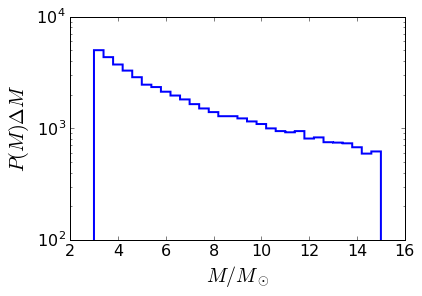

In [83]:
#example plot with M_min=0.5, M_max=5.0, N=1000, with salpeter alpha=2.35
mass_samp = imf_sample(50000,3.0,15.,1.35)
n, bins, patches = plt.hist(mass_samp,bins=30,fill=None,histtype='step',linewidth=2)
plt.yscale('log')
plt.xlabel(r'$M/M_\odot$')
plt.ylabel(r'$P(M)\Delta M$')

The likelihood function for a given set of masses $\vec{m}$ of length $N$ with parameters $\theta=(M_{min},M_{max},\alpha)$, where we are inferring the IMF, is generically
\begin{align}
P(\vec{m}|\theta)&=\prod_{i=1}^NP(m_i|\theta) \\
&= \prod_{i=1}^N \left[\frac{(1-\alpha)}{M_{max}^{1-\alpha}-M_{min}^{1-\alpha}}m_i^{-\alpha}\right] \\
&=\left[\frac{1-\alpha}{M_{max}^{1-\alpha}-M_{min}^{1-\alpha}}\right]^N\prod_{i=1}^N m_i^{-\alpha}
\end{align}

It is easier to deal with the log likelihood, which changes the product to a sum:
\begin{align}
\ln P(\vec{m}|\theta)&=N\ln C+\sum_{i=1}^N \ln(m_i^{-\alpha})\\
&= N\ln C -\alpha\sum_{i=1}^N \ln m_i
\end{align}
where $C=(1-\alpha)/(M_{max}^{1-\alpha}-M_{min}^{1-\alpha})$.

For the prior, we simply enforce that $M_{\rm min}<M_{\rm max}$ and that $\alpha>0$. However, there's an additional prior that can be taken into account based on the data. Namely, for a given set of masses $\vec{m}$, we make the condition

\begin{align}
M_{\rm max}\ge \max\left[\vec{m}\right]
\end{align}

In [8]:
def lnprior(theta):
    m_min = 3.0
    m_max, alpha = theta
    if m_max<=m_min:
        return -np.inf
    if alpha < 0 or alpha==1.:
        return -np.inf
    return 0.0

def lnlikelihood(theta,mass):
    m_max, alpha = theta
    m_min = 3.
    a1 = 1.-alpha
    c = a1/(m_max**a1-m_min**a1)
    if m_max<np.max(mass):
        return -np.inf
    lnP = np.sum(-alpha*np.log(mass)+np.log(c))
    return lnP
    
def lnposterior(theta,mass):
    prior = lnprior(theta)
    likelihood = lnlikelihood(theta,mass)
    return prior + likelihood
    
def cval(theta):
    m_max, alpha = theta
    m_min = 3.
    a1 = 1.-alpha
    return np.log(a1/(m_max**a1-m_min**a1))

In [88]:
data = imf_sample(1000,3.0,15.,1.35)


nwalkers = 50
ndim = 2
p0 = [np.array([30.,2.5]+3.*np.random.rand(2)) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers,ndim,lnposterior,args=([data]))
pos, prob, state = sampler.run_mcmc(p0,200)
sampler.reset()
pos, prob, state = sampler.run_mcmc(p0,2000)
#print(p0)

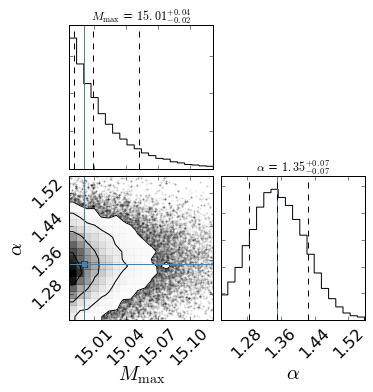

In [89]:
fig = corner.corner(sampler.flatchain,range=[0.9,0.95],quantiles=[.16,.5,.84],
                    labels=[r'$M_{\rm max}$',r'$\alpha$'],label_kwargs={"fontsize":20},show_titles=True,
                   truths=[15.,1.35])

In [63]:
num = 50, 100, 300, 500, 1000, 2000, 5000, 10000
mass = 15.27, 14.23, 14.96, 14.87, 15.02, 15.01, 15., 15
mperr = np.array([1.03,.33,.16,.09,.04,.02,.01,0])
mmerr = np.array([.35,.14,.05,.03,.02,.02,.01,0])
alpha = 1.21,1.16,1.47,1.36,1.37,1.37,1.33,1.33
aperr = np.array([.34,.24,.14,.11,.07,.05,.03,.02])
amerr = np.array([.32,.23,.13,.1,.07,.05,.03,.02])

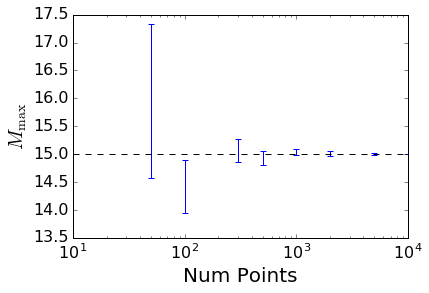

In [79]:
plt.errorbar(num,mass,yerr=[2.*mmerr,2.*mperr],ls='none',lw=1.,capthick=1)
plt.axhline(y=15.,color='black',ls='dashed')
plt.xscale('log')
plt.xlabel("Num Points")
plt.ylabel(r'$M_{\rm max}$')

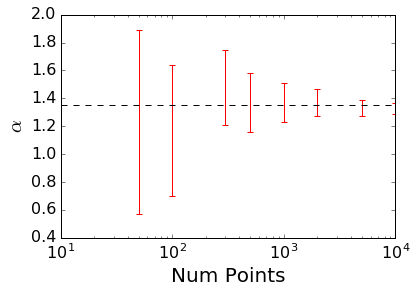

In [81]:
plt.errorbar(num,alpha,yerr=[2.*amerr,2.*aperr],ls='none',lw=1.,capthick=1,color='red')
plt.axhline(y=1.35,color='black',ls='dashed')
plt.xscale('log')
plt.xlabel("Num Points")
plt.ylabel(r'$\alpha$')